# Лабораторная работа 1. Линейная регрессия и факторный анализ

## Описание работы

Цель работы: изучение основ линейной регрессии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качество.

Постановка задачи:

1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ).

2. Подготовить данные: провести первичный анализ, визуализировать распределение признаков и целевой переменной. 

3. Провести предобработку данных: удалить пропущенные значения, закодировать категориальные переменные (опционально).

4. Построить матрицу корреляций. Сделать выводы о наличии мультиколлинеарности (расчет VIF-коэффициента).

5. Построить регрессионные модели (линейная и гребневая). Если целевая переменная - категориальная, то исследовать логистическую регрессию. Разделить на тренировочную и тестовую выборки (80/20 или 70/30). Использовать кросс-валидацию. Оценить качество построенной модели с помощью метрик: RMSE (Root Mean Square Error), R² (коэффициент детерминации) и MAPE (Mean Absolute Percentage Error).

6. Устранить мультиколлинеарность и снизить размерность признаков с помощью метода главных компонент (PCA). Перед проведением PCA провести стандартизацию данных.

7. Повторить шаг 5 (линейная и гребневая регрессия), но использовать в качестве признаков не исходные данные, а главные компоненты. Сравнить метрики качества (RMSE, R² и MAPE) моделей, обученных на исходных данных и на главных компонентах.

## 1. Импорт библиотек/Загрузка репозитория

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('monsters.csv')


## 2. Подготовка данных
### 2.1. Первичный анализ

In [198]:

print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nСтатистики числовых признаков:")
print(df.describe())

Размер датасета: (450, 10)

Первые 5 строк:
                   Name      Sourcebook     CR    XP   HP  AC  DPR  \
0  Aarakocra Aeromancer  Monster Manual   4.00  1100   66  16   42   
1  Aarakocra Skirmisher  Monster Manual   0.25    50   11  12    7   
2      Aberrant Cultist  Monster Manual   8.00  3900  137  14   48   
3               Aboleth  Monster Manual  10.00  5900  150  17   94   
4       Abominable Yeti  Monster Manual   9.00  5000  137  15   72   

   Attack_Mod  Num_Attacks  Is_Legendary  
0           5            2             0  
1           4            1             0  
2           7            2             0  
3           9            3             1  
4          11            3             0  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          450 non-null    object 
 1   Sourcebook    45

### 2.2. Распределение признаков и целевой переменной

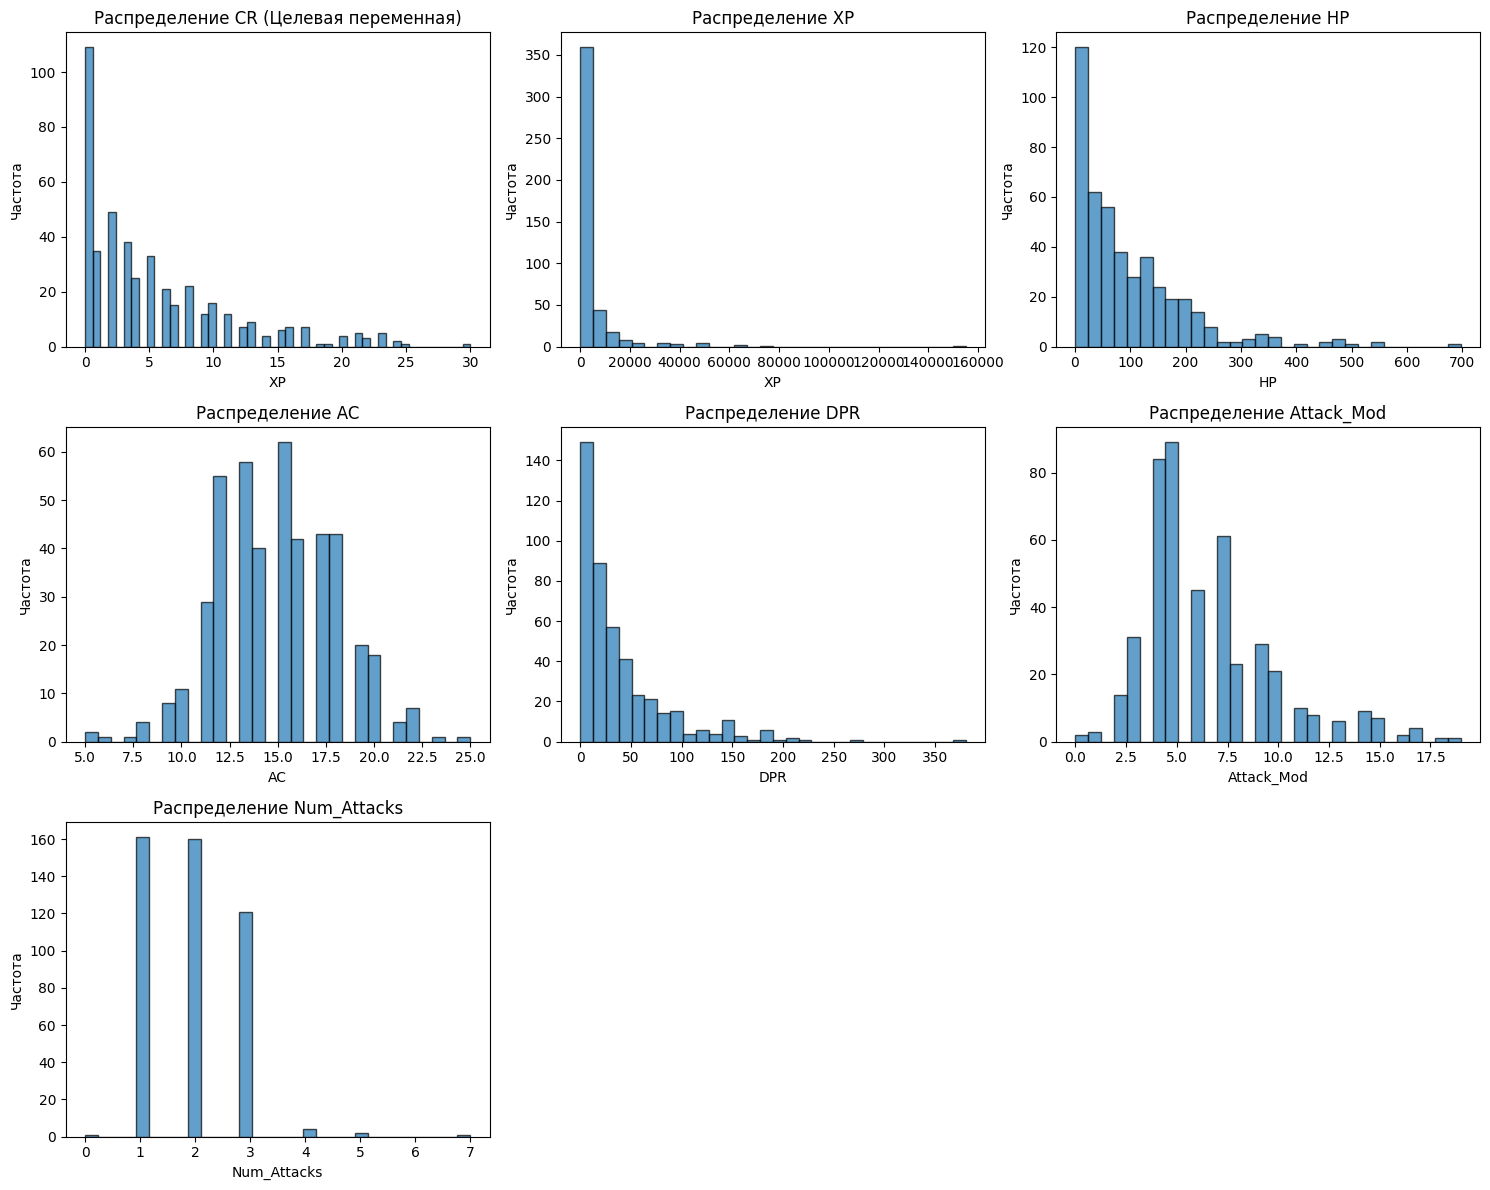

In [199]:
plt.figure(figsize=(15, 12))

plt.subplot(3, 3, 1)
plt.hist(df['CR'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение CR (Целевая переменная)')
plt.xlabel('XP')
plt.ylabel('Частота')

numerical_features = ['XP', 'HP', 'AC', 'DPR', 'Attack_Mod', 'Num_Attacks']
for i, feature in enumerate(numerical_features, 2):
    plt.subplot(3, 3, i)
    plt.hist(df[feature], bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Распределение {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

## 3. Предобработка данных

### 3.1. Удаление пропущенных значений

In [200]:
df_clean = df.dropna()

### 3.2. Кодирование категориальных переменных

In [201]:
data = df.copy()

data = data.drop('Name', axis=1)

print("Уникальные источники:")
print(data['Sourcebook'].value_counts())

data = pd.get_dummies(data, columns=['Sourcebook'], prefix='Source')

print(f"Размер данных после обработки: {data.shape}")

Уникальные источники:
Sourcebook
Monster Manual       407
Player's Handbook     43
Name: count, dtype: int64
Размер данных после обработки: (450, 10)


## 4. Матрица кореляций
### 4.1. Построение

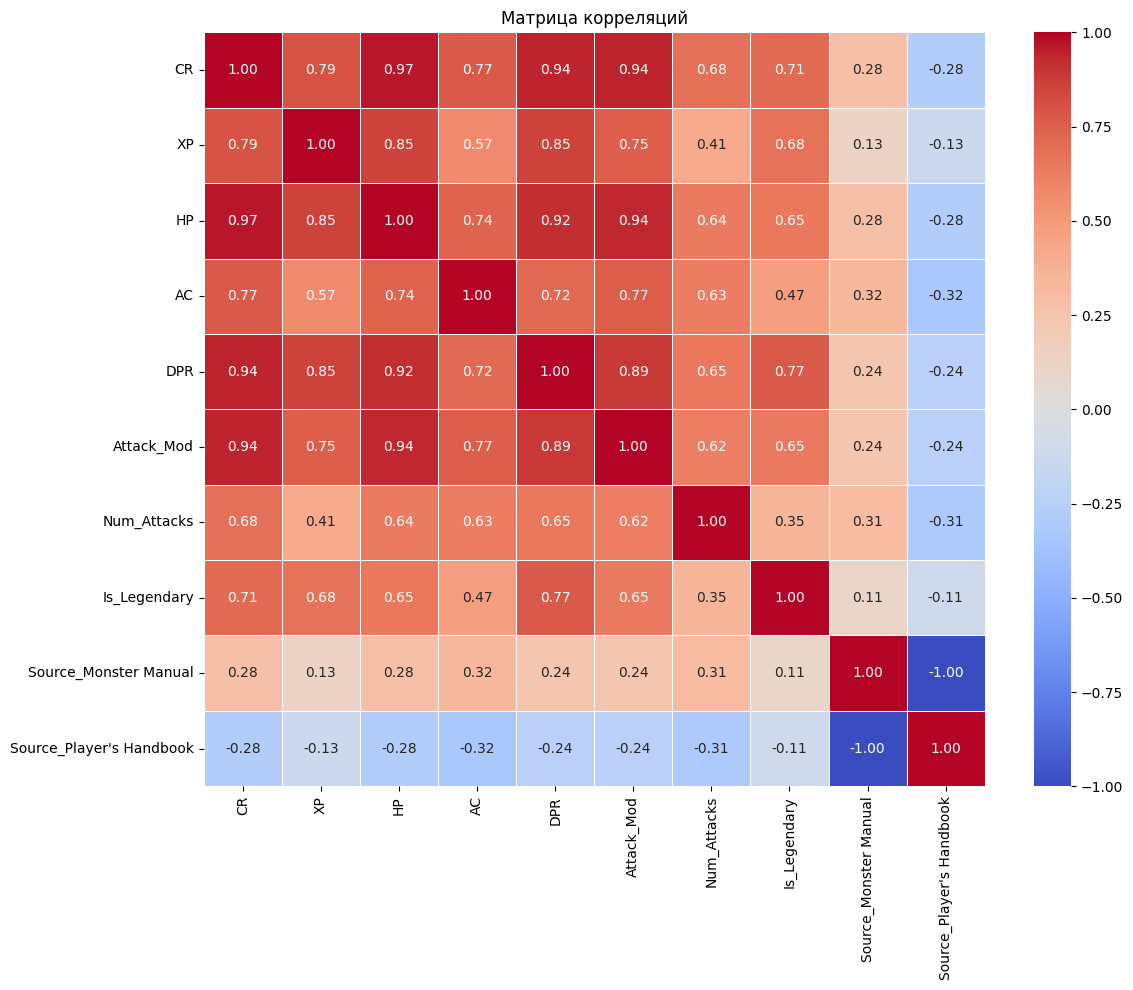

In [202]:
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

### 4.2. Расчет VIF-коэффициента

In [203]:
features_for_vif = data.drop('CR', axis=1)
numeric_df  = features_for_vif.select_dtypes(include=[np.number])
X_with_const = add_constant(numeric_df)

vif_data = pd.DataFrame()
vif_data['Признак'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]

print("VIF коэффициенты:")
print(vif_data.sort_values('VIF', ascending=False))

VIF коэффициенты:
        Признак        VIF
0         const  43.365985
2            HP  16.174392
4           DPR  13.394548
5    Attack_Mod  10.621130
1            XP   6.023769
7  Is_Legendary   2.858251
3            AC   2.664687
6   Num_Attacks   2.495431


Наличие нескольких признаков с VIF > 10 указывает на серьезную проблему мультиколлинеарности в данных. Особое внимание следует уделить признакам HP, DPR и Attack_Mod как основным источникам мультиколлинеарности.

## 5. Построение регрессионных моделей на исходных данных

In [204]:
X = data.drop('CR', axis=1)
y = data['CR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Линейная регрессия': LinearRegression(),
    'Гребневая регрессия': Ridge(alpha=1.0)
}

### 5.2. Функция для оценки моделей

In [205]:
def evaluate_model(model, X_tr, X_te, y_tr, y_te, cv=True):
    model.fit(X_tr, y_tr)
    
    y_pred = model.predict(X_te)
    
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    r2 = r2_score(y_te, y_pred)
    mape = mean_absolute_percentage_error(y_te, y_pred)
    
    if cv:
        cv_scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='r2')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
    else:
        cv_mean, cv_std = None, None

    return rmse, r2, mape, cv_mean, cv_std

### 5.3. Оценка качества построенной модели

In [206]:
results_original = {}

for name, model in models.items():
    if name == 'Линейная регрессия':
        rmse, r2, mape, cv_mean, cv_std = evaluate_model(model, X_train, X_test, y_train, y_test)
    else:
        rmse, r2, mape, cv_mean, cv_std = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    
    results_original[name] = {'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'CV_R2_mean': cv_mean, 'CV_R2_std': cv_std}
    
    print(f"\n{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  CV R²: {cv_mean:.4f} (±{cv_std:.4f})")


Линейная регрессия:
  RMSE: 1.08
  R²: 0.9626
  MAPE: 150299047251092.8438
  CV R²: 0.9688 (±0.0077)

Гребневая регрессия:
  RMSE: 1.07
  R²: 0.9633
  MAPE: 160523267270882.6250
  CV R²: 0.9683 (±0.0067)


Обе модели демонстрируют превосходное качество предсказания CR монстров. Несмотря на аномальный MAPE (из-за большего количества CR < 1), основные метрики (R², RMSE) указывают на то, что модели успешно решают поставленную задачу.

## 6. PCA

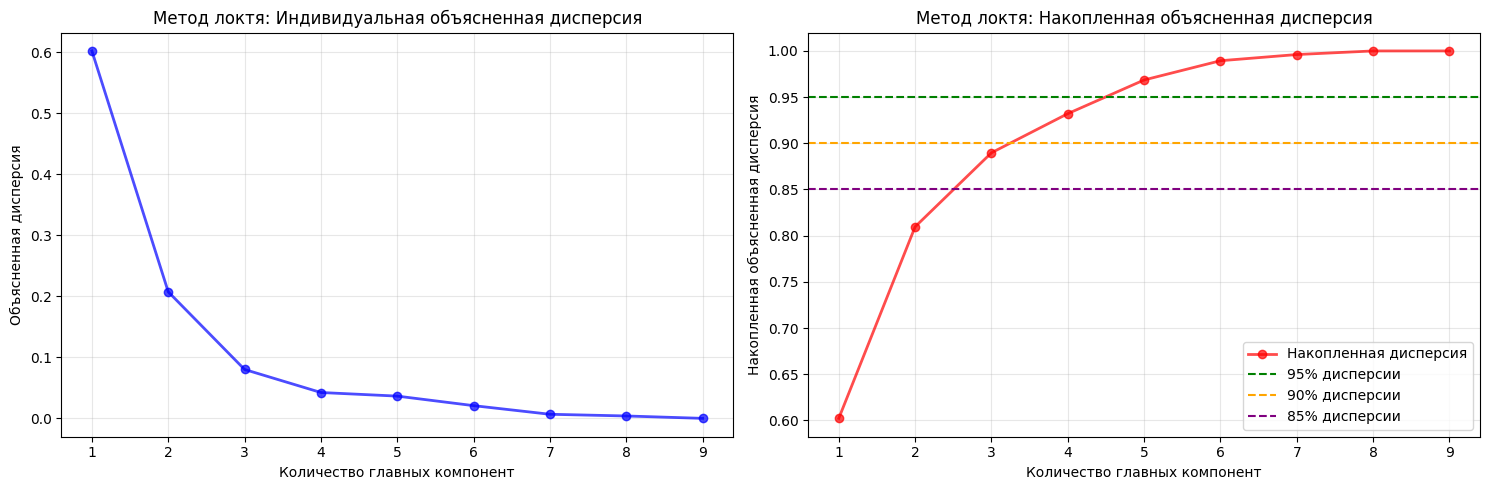

Компоненты для 85% дисперсии: 3
Компоненты для 90% дисперсии: 4
Компоненты для 95% дисперсии: 5

Выбрано компонент для PCA: 4 (90% объясненной дисперсии)
Исходная размерность признаков: 9
Размерность после PCA: 4
Сохраненная дисперсия: 93.211%


In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-', 
         linewidth=2, markersize=6, alpha=0.7)
plt.xlabel('Количество главных компонент')
plt.ylabel('Объясненная дисперсия')
plt.title('Индивидуальная объясненная дисперсия')
plt.grid(True, alpha=0.3)


plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', 
         linewidth=2, markersize=6, alpha=0.7, label='Накопленная дисперсия')
plt.axhline(y=0.95, color='green', linestyle='--', label='95% дисперсии')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% дисперсии')
plt.axhline(y=0.85, color='purple', linestyle='--', label='85% дисперсии')
plt.xlabel('Количество главных компонент')
plt.ylabel('Накопленная объясненная дисперсия')
plt.title('Накопленная объясненная дисперсия')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Компоненты для 85% дисперсии: {n_components_85}")
print(f"Компоненты для 90% дисперсии: {n_components_90}") 
print(f"Компоненты для 95% дисперсии: {n_components_95}")


optimal_components = n_components_90
print(f"\nВыбрано компонент для PCA: {optimal_components} (90% объясненной дисперсии)")


pca_final = PCA(n_components=optimal_components)
X_train_pca_final = pca_final.fit_transform(X_train_scaled)
X_test_pca_final = pca_final.transform(X_test_scaled)

print(f"Исходная размерность признаков: {X_train_scaled.shape[1]}")
print(f"Размерность после PCA: {X_train_pca_final.shape[1]}")
print(f"Сохраненная дисперсия: {pca_final.explained_variance_ratio_.sum():.3%}")

## 7. Построение моделей на главных компонентах

In [208]:
# Построение моделей на главных компонентах
results_pca = {}

print("Метрики моделей на главных компонентах:")
for name, model in models.items():
    rmse, r2, mape, cv_mean, cv_std = evaluate_model(model, X_train_pca_final, X_test_pca_final, y_train, y_test)
    
    results_pca[name] = {'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'CV_R2_mean': cv_mean, 'CV_R2_std': cv_std}
    
    print(f"\n{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.4f}")
    print(f"  CV R²: {cv_mean:.4f} (±{cv_std:.4f})")

Метрики моделей на главных компонентах:

Линейная регрессия:
  RMSE: 1.33
  R²: 0.9432
  MAPE: 315997541411348.8750
  CV R²: 0.9248 (±0.0270)

Гребневая регрессия:
  RMSE: 1.33
  R²: 0.9432
  MAPE: 315691325484125.5000
  CV R²: 0.9249 (±0.0268)



Сравнительная таблица метрик:
                Модель    Данные    RMSE      R2          MAPE  CV_R2_mean
0   Линейная регрессия  Исходные  1.0813  0.9626  1.502990e+14      0.9688
1   Линейная регрессия       PCA  1.3330  0.9432  3.159975e+14      0.9248
2  Гребневая регрессия  Исходные  1.0719  0.9633  1.605233e+14      0.9683
3  Гребневая регрессия       PCA  1.3333  0.9432  3.156913e+14      0.9249


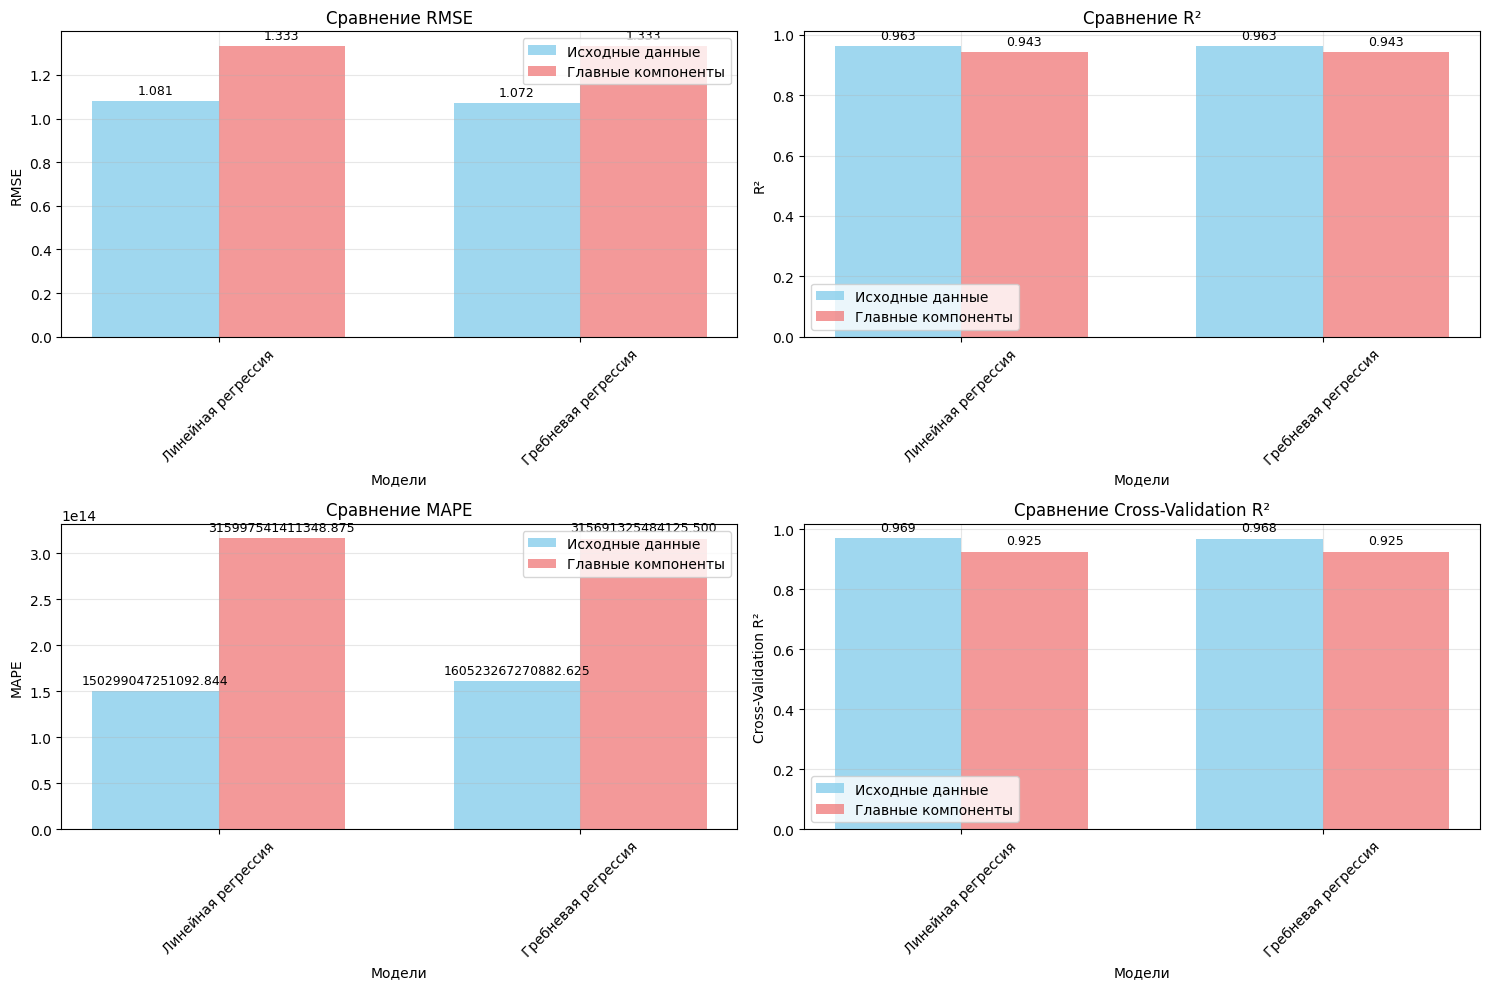

In [213]:
comparison_data = []

for model_name in models.keys():
    orig = results_original[model_name]
    comparison_data.append({
        'Модель': model_name,
        'Данные': 'Исходные',
        'RMSE': orig['RMSE'],
        'R2': orig['R2'],
        'MAPE': orig['MAPE'],
        'CV_R2_mean': orig['CV_R2_mean']
    })
    
    pca = results_pca[model_name]
    comparison_data.append({
        'Модель': model_name,
        'Данные': 'PCA',
        'RMSE': pca['RMSE'],
        'R2': pca['R2'],
        'MAPE': pca['MAPE'], 
        'CV_R2_mean': pca['CV_R2_mean']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nСравнительная таблица метрик:")
print(comparison_df.round(4))



fig, axes = plt.subplots(2, 2, figsize=(15, 10))

models_list = list(models.keys())

metrics_to_compare = [
    ('RMSE', 'RMSE'),
    ('R2', 'R²'), 
    ('MAPE', 'MAPE'),
    ('CV_R2_mean', 'Cross-Validation R²')
]

for idx, (metric_key, metric_name) in enumerate(metrics_to_compare):
    ax = axes[idx//2, idx%2]
    

    original_values = [results_original[model][metric_key] for model in models_list]
    pca_values = [results_pca[model][metric_key] for model in models_list]
    
    x = np.arange(len(models_list))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, original_values, width, label='Исходные данные', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, pca_values, width, label='Главные компоненты', alpha=0.8, color='lightcoral')
    
    ax.set_xlabel('Модели')
    ax.set_ylabel(metric_name)
    ax.set_title(f'Сравнение {metric_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(models_list, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
   
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 8. Итоги

In [219]:
best_original = max(results_original.items(), key=lambda x: x[1]['R2'])
best_pca = max(results_pca.items(), key=lambda x: x[1]['R2'])

print(f"Лучшая модель на исходных данных: {best_original[0]} (R² = {best_original[1]['R2']:.4f})")
print(f"Лучшая модель на главных компонентах: {best_pca[0]} (R² = {best_pca[1]['R2']:.4f})")
print(f"Общее качество моделей: {'ХОРОШЕЕ' if best_original[1]['R2'] > 0.7 else 'УДОВЛЕТВОРИТЕЛЬНОЕ' if best_original[1]['R2'] > 0.5 else 'НИЗКОЕ'}")
print(f"Модели успешно предсказывают Challenge Rating (CR) монстров")

Лучшая модель на исходных данных: Гребневая регрессия (R² = 0.9633)
Лучшая модель на главных компонентах: Линейная регрессия (R² = 0.9432)
Общее качество моделей: ХОРОШЕЕ
Модели успешно предсказывают Challenge Rating (CR) монстров


Применение PCA позволило успешно устранить мультиколлинеарность, сократив размерность с 9 до 4 признаков при сохранении 93% дисперсии, однако это привело к умеренному снижению качества моделей: R² уменьшился с 0.963 до 0.943, а RMSE вырос с 1.07 до 1.33, при этом устойчивость моделей на кросс-валидации значительно ухудшилась. Обе регрессионные модели показали идентичные результаты на главных компонентах, что подтверждает эффективность PCA в устранении мультиколлинеарности, но для практического предсказания CR монстров лучше использовать исходные данные ввиду более высокой точности, тогда как главные компоненты больше подходят для аналитических целей и интерпретации взаимосвязей между признаками.